In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE

from utils import get_loaders, get_features
from models import SSLNet
from trainers import train_ssd
from evals import evaluate

print(torch.cuda.is_available())

True


In [2]:
config = {
    'method': 'ssd',
    'temperature': 0.07,
    'contrast_mode': 'one',
    
    # Training
    'epochs': 1000,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'patience': 20,
    'min_delta': 1e-8,
    'sched_patience': 10,
    'sched_factor': 0.5,
    
    # Network
    'dims' : [30, 16, 8],
    'drop': 0.1,
    'norm': True,
    'activation': 'ReLU',
    
    # Dataset
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 1024,
    
    # Utility
    'seed': 15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_path': './Data/creditcard.csv',
    'print_freq': 20,
}

In [3]:
train_loader, val_loader, test_loader = get_loaders(config['data_path'], config['val_split'], config['test_split'], config['seed'], config['batch_size'], config['method'])

(230693, 31) (25633, 31) (28481, 31)


# Training SSD

In [32]:
model = SSLNet(config).to(config['device'])
print(model)

config['temperature'] = 0.05
config['seed'] = 15

SSLNet(
  (embeddings): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
)


In [33]:
model, train_losses, val_losses, train_ap, val_ap, train_fpr, val_fpr = train_ssd(model, train_loader, val_loader, config)

Epoch 1 | Train Loss: 5.1957 | Val Loss: 3.1300 | Train AUPRC: 0.0843 | Val AUPRC: 0.1321 | Train FPR@95TPR: 0.1980 | Val FPR@95TPR: 0.1136 | Best Epoch: 0
Epoch 5 | Train Loss: 4.0595 | Val Loss: 2.9258 | Train AUPRC: 0.0852 | Val AUPRC: 0.1078 | Train FPR@95TPR: 0.1805 | Val FPR@95TPR: 0.1136 | Best Epoch: 4
Epoch 10 | Train Loss: 3.7717 | Val Loss: 2.8219 | Train AUPRC: 0.0889 | Val AUPRC: 0.1503 | Train FPR@95TPR: 0.1855 | Val FPR@95TPR: 0.1136 | Best Epoch: 9
Epoch 15 | Train Loss: 3.6534 | Val Loss: 2.7780 | Train AUPRC: 0.1126 | Val AUPRC: 0.2469 | Train FPR@95TPR: 0.2055 | Val FPR@95TPR: 0.0909 | Best Epoch: 14
Epoch 20 | Train Loss: 3.5899 | Val Loss: 2.7526 | Train AUPRC: 0.1168 | Val AUPRC: 0.2339 | Train FPR@95TPR: 0.1880 | Val FPR@95TPR: 0.1136 | Best Epoch: 19
Epoch 25 | Train Loss: 3.5372 | Val Loss: 2.7314 | Train AUPRC: 0.1208 | Val AUPRC: 0.2209 | Train FPR@95TPR: 0.2682 | Val FPR@95TPR: 0.1136 | Best Epoch: 24
Epoch 30 | Train Loss: 3.4985 | Val Loss: 2.7183 | Train 

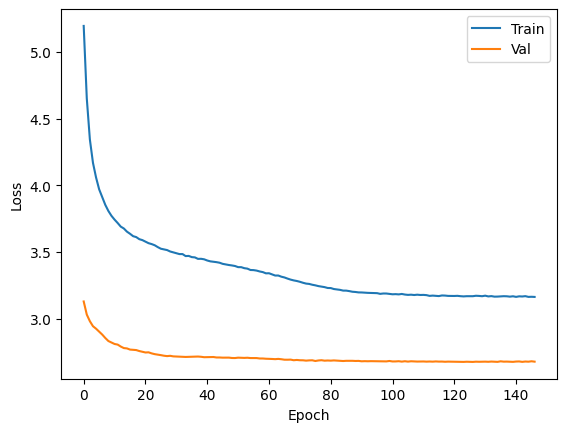

In [34]:
# Plot the loss
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

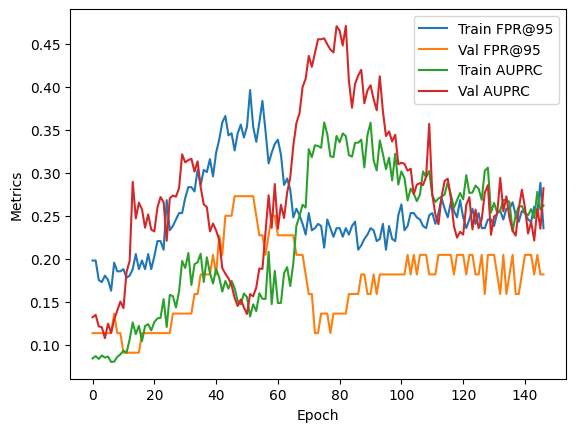

In [35]:
#Plot the metrics
plt.plot(train_fpr, label = "Train FPR@95")
plt.plot(val_fpr, label = "Val FPR@95")
plt.plot(train_ap, label = "Train AUPRC")
plt.plot(val_ap, label = "Val AUPRC")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()
plt.show()

In [36]:
test_ap, test_fpr = evaluate(model, train_loader, test_loader)

In [37]:
print(f'Train FPR@95: {train_fpr[-config['patience']]:.4f}, Val FPR@95: {val_fpr[-config['patience']]:.4f}, Test FPR@95: {test_fpr:.4f}')
print(f'Train AUPRC: {train_ap[-config['patience']]:.4f}, Val AUPRC: {val_ap[-config['patience']]:.4f}, Test AUPRC: {test_ap:.4f}')

Train FPR@95: 0.2356, Val FPR@95: 0.1591, Test FPR@95: 0.2041
Train AUPRC: 0.3024, Val AUPRC: 0.2767, Test AUPRC: 0.3188


In [55]:
# Get embeddings
z_train, y_train = get_features(model, train_loader)
z_val, y_val = get_features(model, val_loader)
z_test, y_test = get_features(model, test_loader)

# Sample only 1000 points from normal, but all frauds
n_train = pd.DataFrame(z_train[y_train == 0])
n_val = pd.DataFrame(z_val[y_val == 0])
n_test = pd.DataFrame(z_test[y_test == 0])

n_train = n_train.sample(1000, random_state=15)
n_val = n_val.sample(1000, random_state=15)
n_test = n_test.sample(1000, random_state=15)

z_train = pd.concat([n_train, pd.DataFrame(z_train[y_train == 1])], axis=0).values
z_val = pd.concat([n_val, pd.DataFrame(z_val[y_val == 1])], axis=0).values
z_test = pd.concat([n_test, pd.DataFrame(z_test[y_test == 1])], axis=0).values

y_train = np.concatenate([np.zeros(1000), np.ones(z_train.shape[0] - 1000)])
y_val = np.concatenate([np.zeros(1000), np.ones(z_val.shape[0] - 1000)])
y_test = np.concatenate([np.zeros(1000), np.ones(z_test.shape[0] - 1000)])

# TSNE
z_train_2d = TSNE(n_components=2).fit_transform(z_train)
z_val_2d = TSNE(n_components=2).fit_transform(z_val)
z_test_2d = TSNE(n_components=2).fit_transform(z_test)

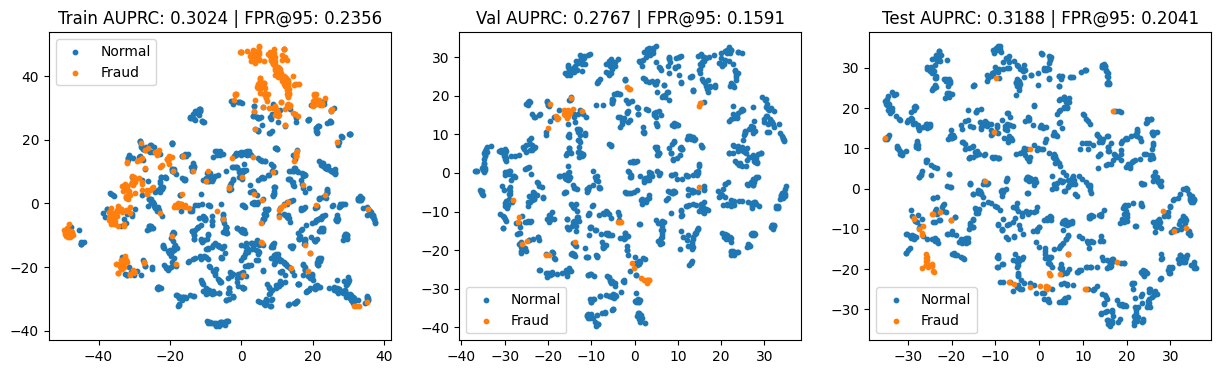

In [61]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.scatter(z_train_2d[y_train == 0, 0], z_train_2d[y_train == 0, 1], s=10, label='Normal')
plt.scatter(z_train_2d[y_train == 1, 0], z_train_2d[y_train == 1, 1], s=10, label='Fraud')
plt.title(f'Train AUPRC: {train_ap[-config['patience']]:.4f} | FPR@95: {train_fpr[-config['patience']]:.4f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(z_val_2d[y_val == 0, 0], z_val_2d[y_val == 0, 1], s=10, label='Normal')
plt.scatter(z_val_2d[y_val == 1, 0], z_val_2d[y_val == 1, 1], s=10, label='Fraud')
plt.title(f'Val AUPRC: {val_ap[-config['patience']]:.4f} | FPR@95: {val_fpr[-config['patience']]:.4f}')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(z_test_2d[y_test == 0, 0], z_test_2d[y_test == 0, 1], s=10, label='Normal')
plt.scatter(z_test_2d[y_test == 1, 0], z_test_2d[y_test == 1, 1], s=10, label='Fraud')
plt.title(f'Test AUPRC: {test_ap:.4f} | FPR@95: {test_fpr:.4f}')
plt.legend()
plt.show()